In [2]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np

import json

with open('new_data.json', 'r') as inp:
    data = json.load(inp)

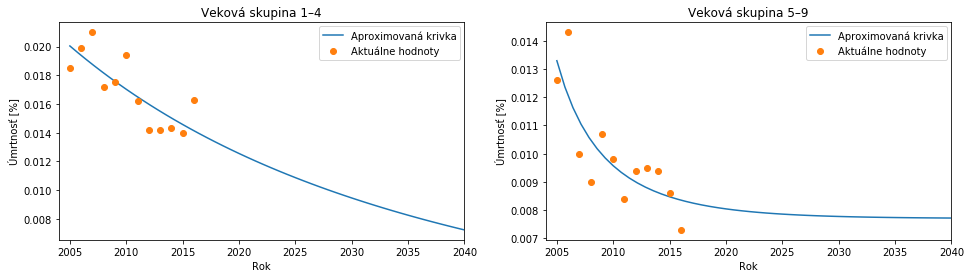

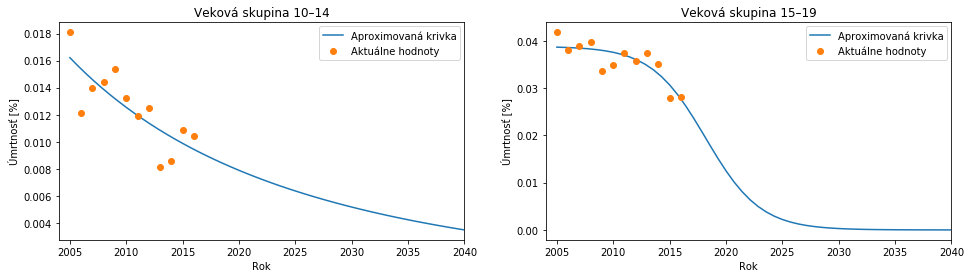

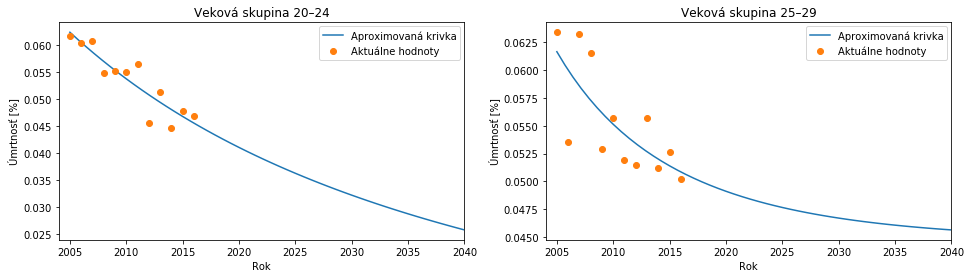

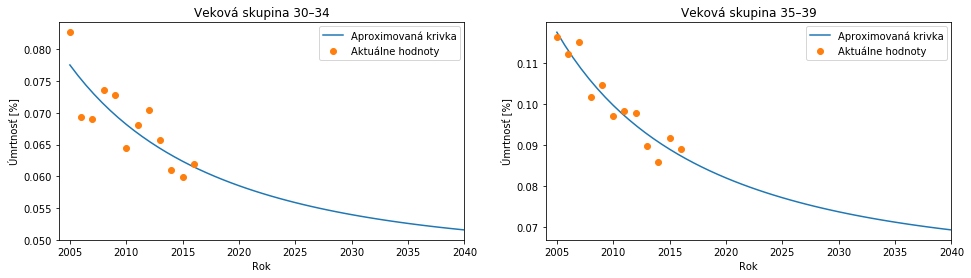

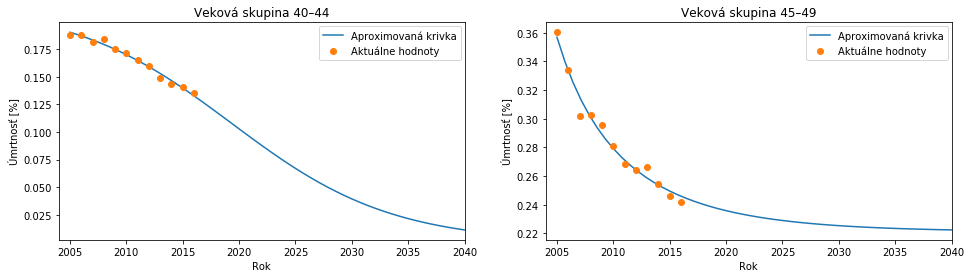

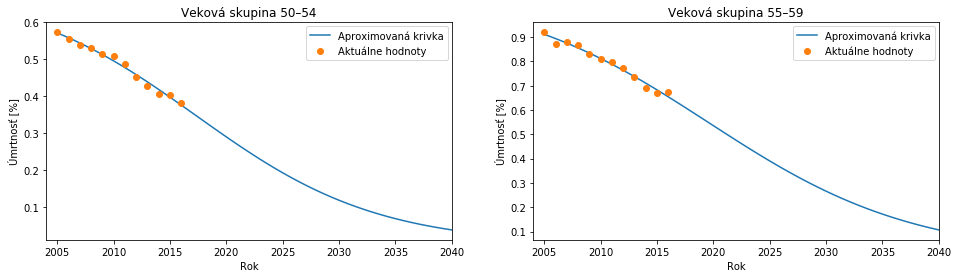

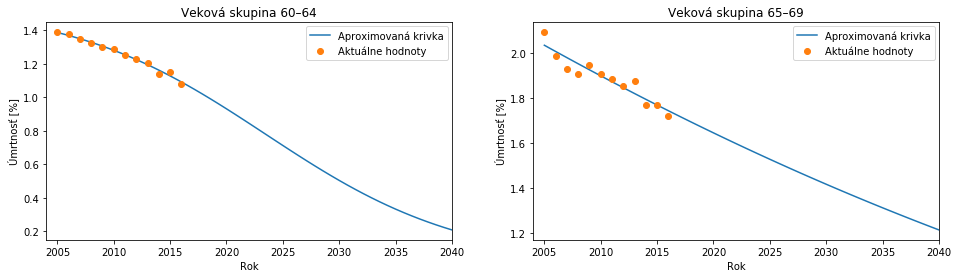

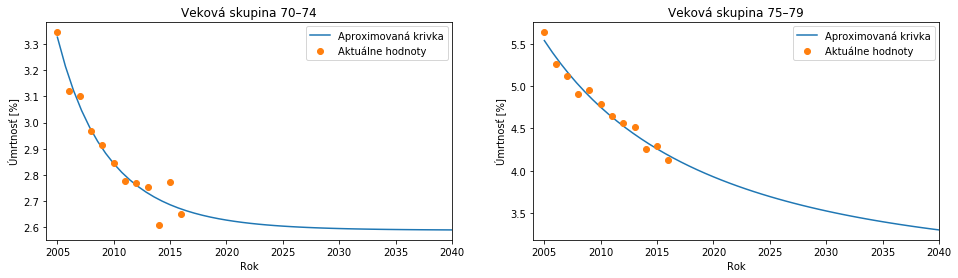

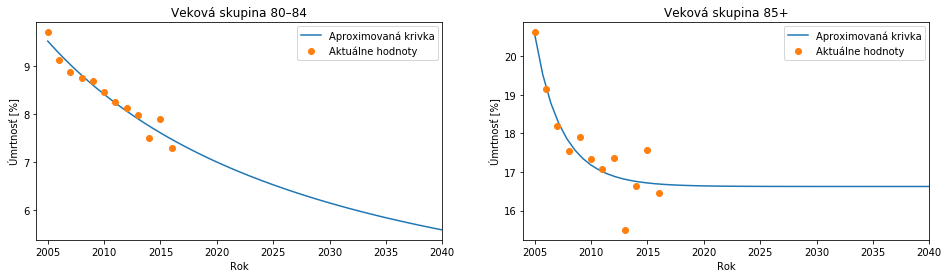

In [59]:
def model_down(val, x):
    return np.absolute(val[0] / (x**val[1] + val[2]))

def model_up(val, x):
    return np.absolute(val[0] + val[1] * x**val[2])

def func_down(val, x, y):
    return model_down(val, x) - y

def func_up(val, x, y):
    return model_up(val, x) - y


x_o = np.array(data['years'][-12:])
x = x_o / x_o.max()

ress = []
num = 0
plt.rcParams['figure.figsize'] = [16, 4]
for part, name in zip(data['data'], data['names']):
    if name == '0':
        continue
    
    if num % 2 == 0:
        plt.show()
    y = np.array(part[-12:])
    y = y / 10**3

    x0 = np.array([1, 1, 1])
    
    res = least_squares(func_down, x0, args=(x, y))
    ress.append(res)
    xnew = np.linspace(x.min(), 2040/x_o.max(), 50)
    
    plt.subplot(1, 2, (num % 2) + 1)
    num += 1
    plt.xlabel('Rok')
    plt.ylabel('Úmrtnosť [%]')
    plt.title('Veková skupina ' + name)
    plt.plot(xnew * x_o.max(), model_down(res.x, xnew), '-',label="Aproximovaná krivka")
    plt.plot(x * x_o.max(), y , 'o', label='Aktuálne hodnoty')
    plt.xlim(2004, 2040)
    plt.legend(borderaxespad=0.4)
plt.show()

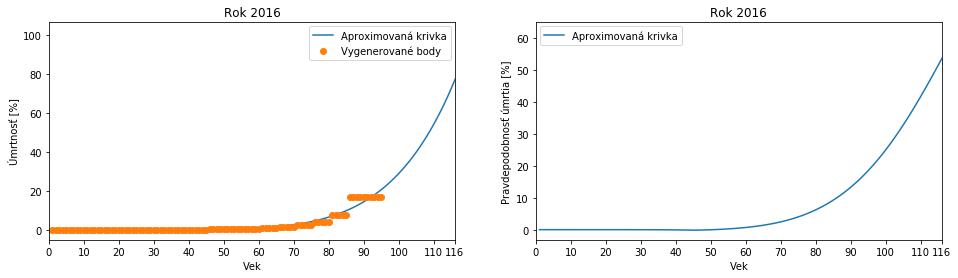

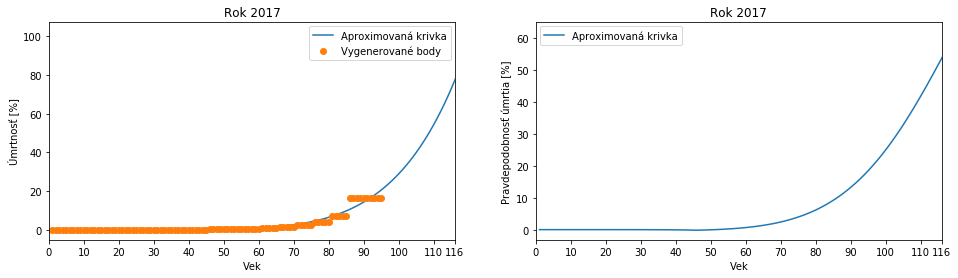

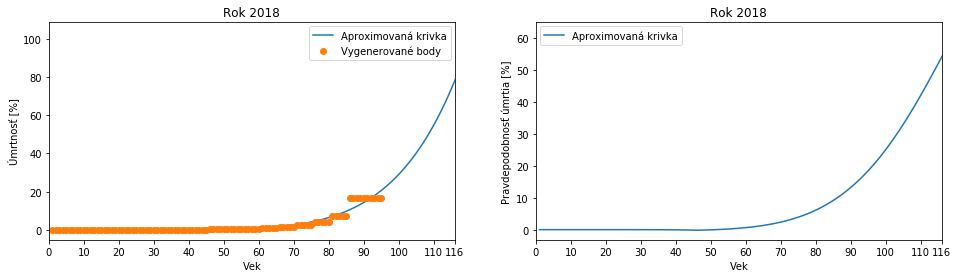

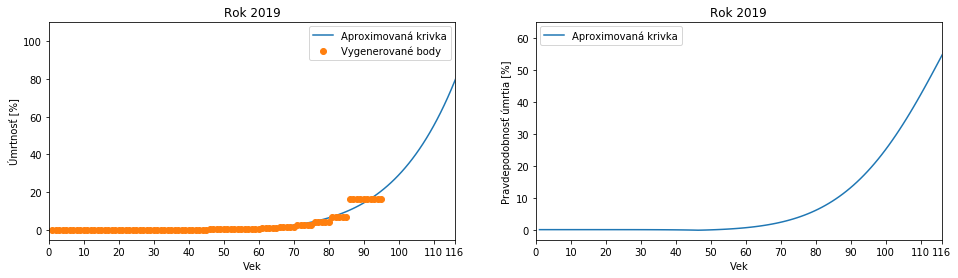

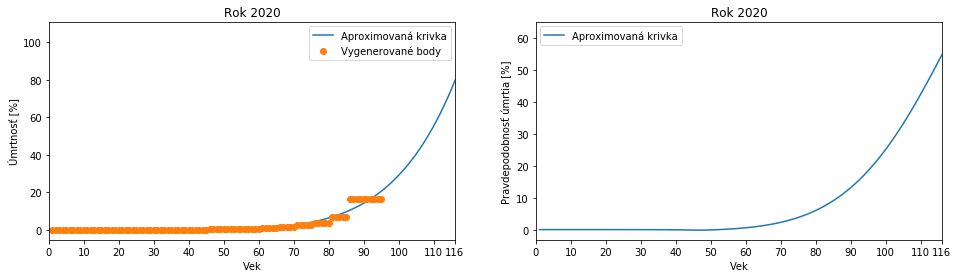

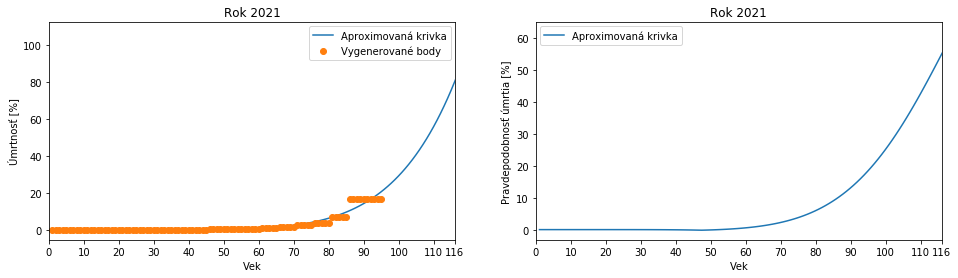

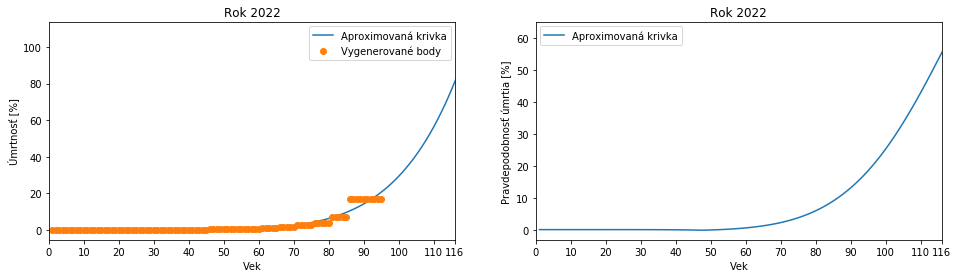

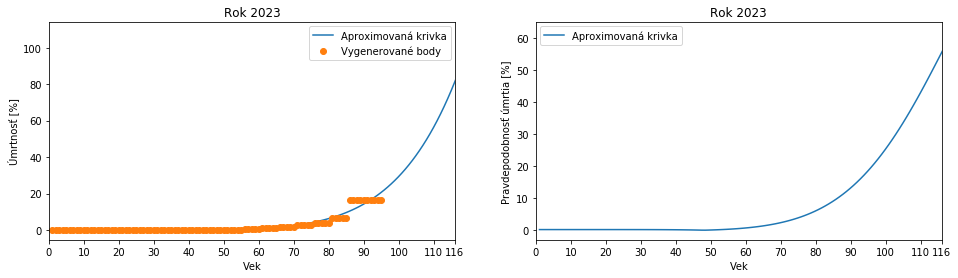

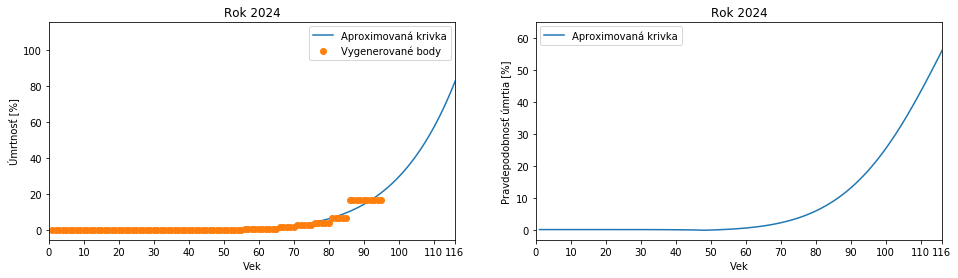

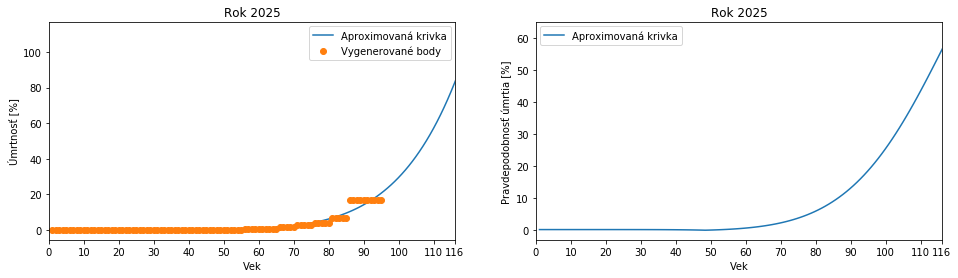

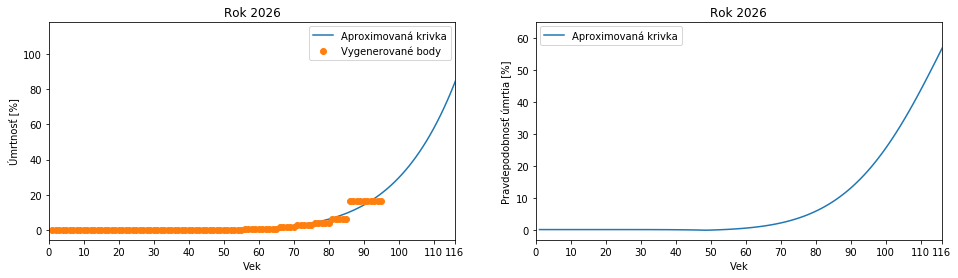

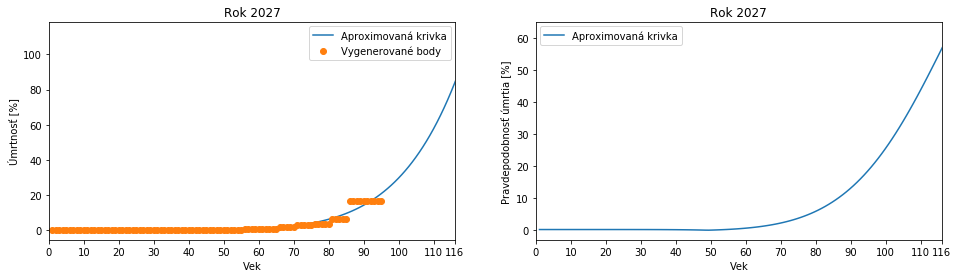

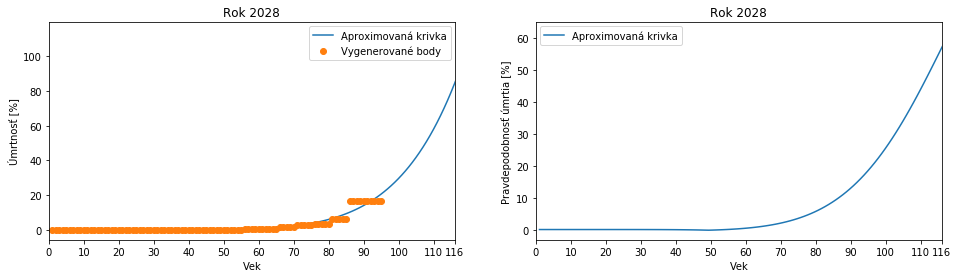

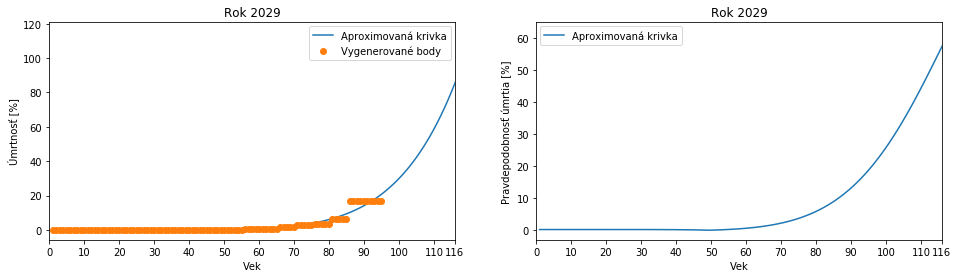

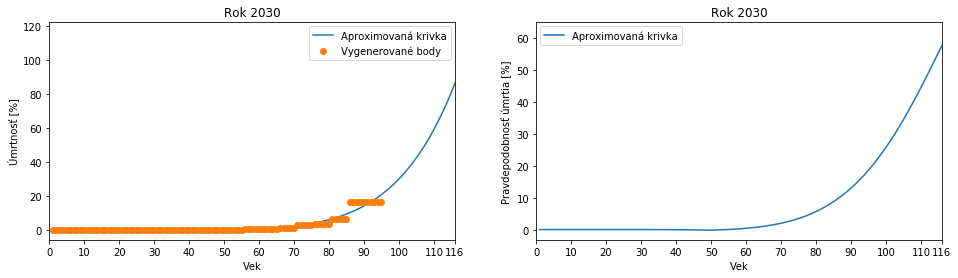

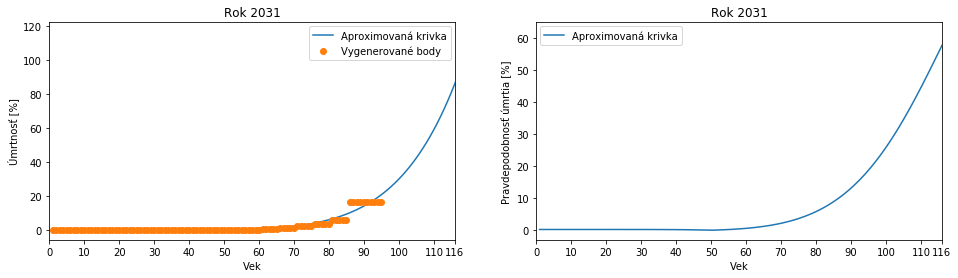

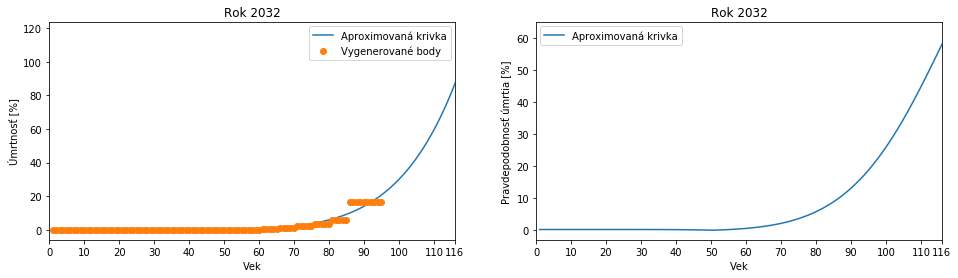

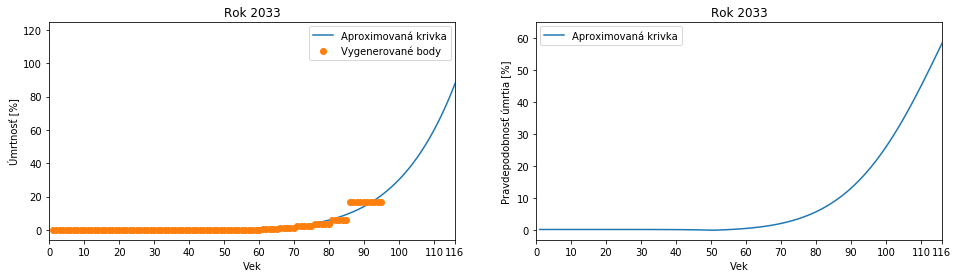

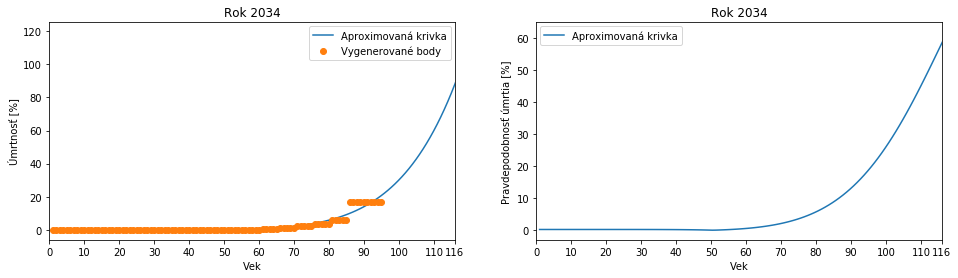

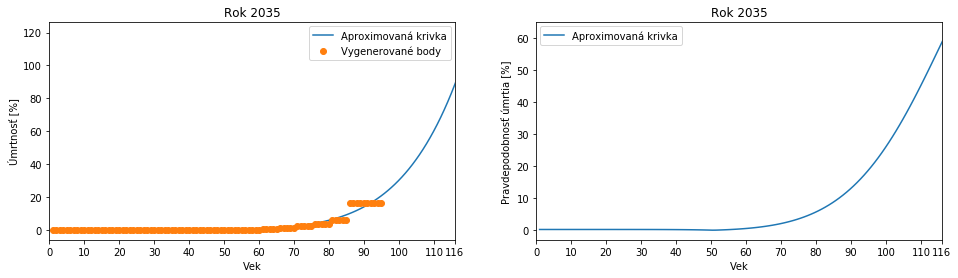

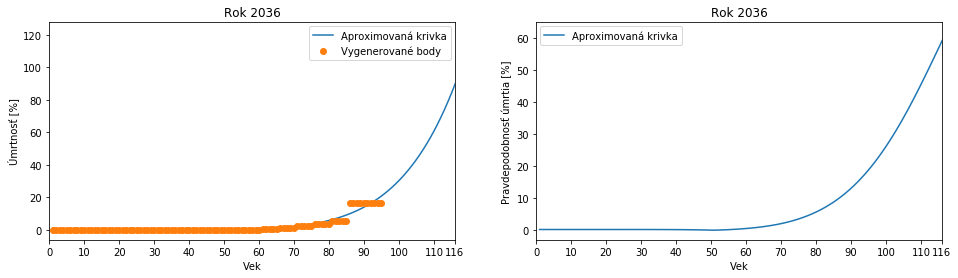

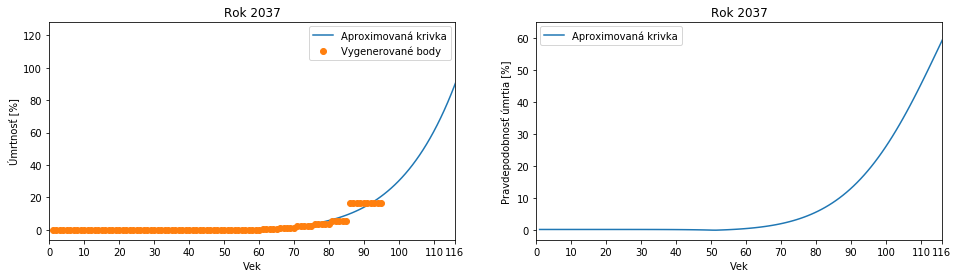

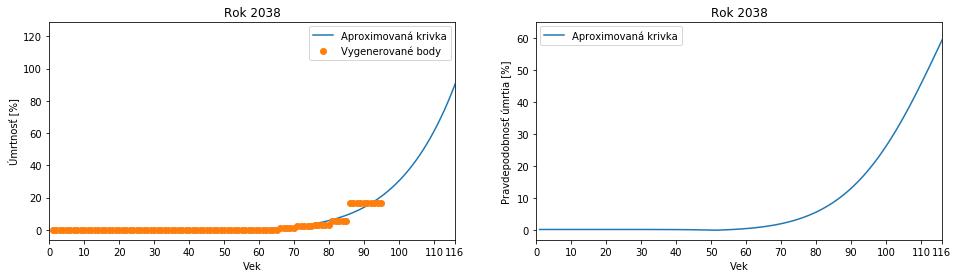

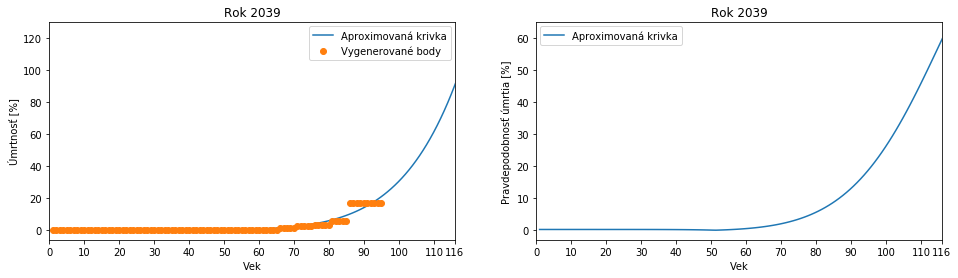

In [25]:
def perc(res, x):
    return model_up(res, x)/100

for year in range(2016, 2040):
    values = []
    for res in ress:
        val = model_down(res.x, year/2016)
        values += [val] * 5
    values += [values[-1]] * 5
    
    y = np.array(values)
    x = np.array(range(1, len(values) + 1))

    x0 = np.array([1, 1, 1])
    res = least_squares(func_up, x0,args=(x, y))
    
    xnew = np.linspace(1, 121, 120)
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.subplot(1, 2, 1)
    plt.title('Rok {}'.format(year))
    plt.xlabel('Vek')
    plt.ylabel('Úmrtnosť [%]')
    plt.plot(xnew, model_up(res.x, xnew), '-', label="Aproximovaná krivka")
    plt.plot(x , y , 'o', label='Vygenerované body')
    plt.legend(borderaxespad=0.4)
    #plt.ylim(0,100)
    plt.xlim(0, 116)
    plt.xticks(list(range(0, 116, 10)) + [116])
    
    plt.subplot(1, 2, 2)
    plt.title('Rok {}'.format(year))
    plt.xlabel('Vek')
    plt.ylabel('Pravdepodobnosť úmrtia [%]')
    plt.plot(xnew, (1 - np.exp(-perc(res.x, xnew))) * 100, '-', label="Aproximovaná krivka")
    plt.legend(loc=2, borderaxespad=0.4)
    plt.ylim(-3, 65)
    plt.xlim(0, 116)
    plt.xticks(list(range(0, 116, 10)) + [116])
    plt.show()


In [3]:
from controller import Controller

In [16]:
controller = Controller('new_data.json', 2041)

In [10]:
tmp = []
sm = []
num = []
for i in controller.clr:
    ppl = round(i.alive())
    if ppl != 0:
        tmp.append(ppl)
    num.append(ppl)
    if len(num) == 5:
        sm.append(sum(num))
        num = []

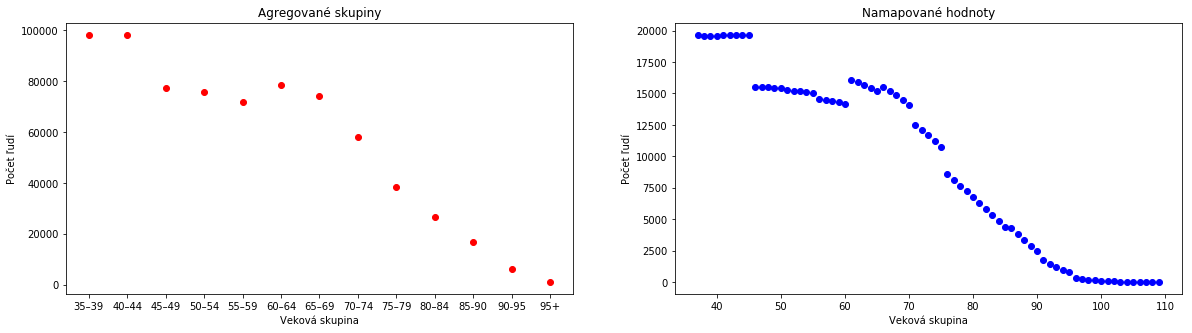

In [6]:

plt.rcParams['figure.figsize'] = [20, 5]
plt.figure(1)
plt.subplot(1, 2, 1)
rl = sm[:-4] + [sum(sm[-4:])]
nms = data['names'][1:-1] + ['85-90', '90-95', '95+']
plt.plot(nms[-13:], rl[-13:], 'ro')
plt.title('Agregované skupiny')
plt.xlabel('Veková skupina')
plt.ylabel('Počet ľudí')

plt.subplot(1, 2, 2)
plt.title('Namapované hodnoty')
plt.xlabel('Veková skupina')
plt.ylabel('Počet ľudí')
sh_y = tmp[36:]
sh_x = range(1, len(tmp) +1)
plt.plot(sh_x[36:], sh_y, 'bo')

plt.show()

In [17]:
exp_data = [[], [], []]
exp_perc = [[0.001570500134, 0.002818625599, 0.01876894202, 0.0758],
            [0.001389275368, 0.001934861389, 0.01536942765, 0.1054],
            [0, 0.0, 0.0, 0.165]]

while controller.clr[0].year != 2041:
    tmp = [[0, 0, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 0]]

    for index, part in enumerate([controller.clr[60:65],
                                  controller.clr[65:75],
                                  controller.clr[75:85],
                                  controller.clr[85:]]):
        for age_block in part:
            for tm, perc in zip(tmp, exp_perc):
                tm[index] += age_block.alive() * perc[index]

    for ex, tm in zip(exp_data, tmp):
        ex.append(tm)

    controller.resolve_year()

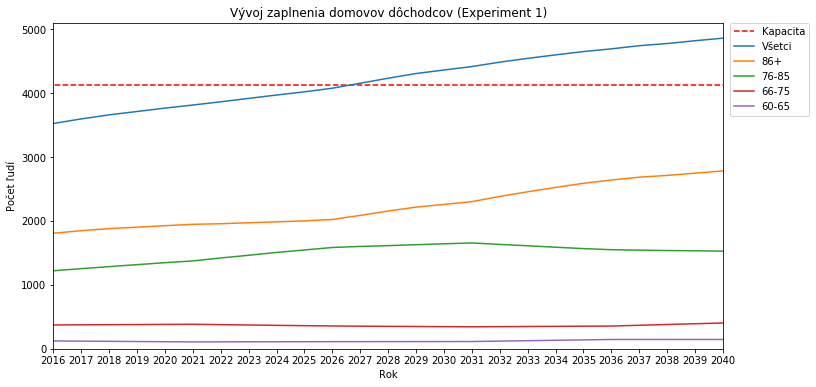

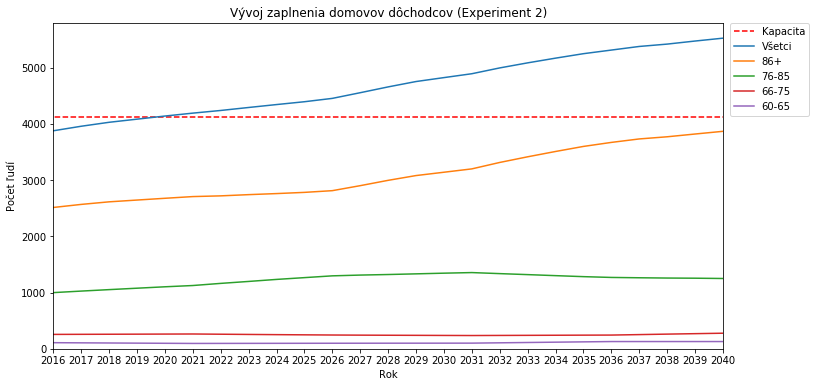

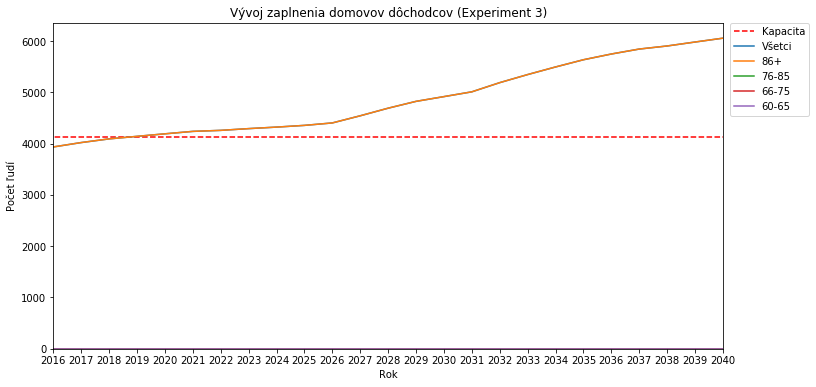

In [18]:
plt.rcParams['figure.figsize'] = [12, 6]
years = list(range(2016, 2041))
for num, exp in enumerate(exp_data, 1):
    data = list(zip(*exp))
    data_max = [sum(x) for x in zip(*data)]
    #print(data_max)
    plt.figure(num)
    plt.plot([0, 2040], [4128, 4128], 'r--', label='Kapacita')
    plt.plot(years, data_max, label='Všetci')
    plt.plot(years, data[3], label='86+')
    plt.plot(years, data[2], label='76-85')
    plt.plot(years, data[1], label='66-75')
    plt.plot(years, data[0], label='60-65')
    plt.ylim(0, max(data_max)*1.05)
    plt.xlim(2016, 2040)
    plt.xticks(list(range(2016, 2041, 1)))
    plt.title('Vývoj zaplnenia domovov dôchodcov (Experiment {})'.format(num))
    plt.xlabel('Rok')
    plt.ylabel('Počet ľudí')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.show()